In [2]:
import os
import warnings


import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from feature_engine.outliers import Winsorizer 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import joblib


In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../artifacts/data_ingestion/loanDataset.csv')

In [5]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67.0,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22.0,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49.0,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45.0,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53.0,none,other,2,skilled,2,no,yes


#### separate numerical and non-numerical columns 

In [6]:
numeric_features = df.select_dtypes(exclude = ['object']).columns

In [7]:
numeric_features

Index(['months_loan_duration', 'amount', 'percent_of_income',
       'years_at_residence', 'age', 'existing_loans_count', 'dependents'],
      dtype='object')

In [8]:
categorical_features = df.select_dtypes(include=['object']).columns

In [9]:
categorical_features

Index(['checking_balance', 'credit_history', 'purpose', 'savings_balance',
       'employment_duration', 'other_credit', 'housing', 'job', 'phone',
       'default'],
      dtype='object')

#### Imputation to handle missing values and scaling

In [10]:
num_pipeLine = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean')), ('Scale', MinMaxScaler())])

#### Pipeline for Onehotencoding -> convert Categorical data to Numeric data

In [11]:
encoding_pipeline = Pipeline([('onehot', OneHotEncoder(sparse_output=False))])

In [12]:

preprocess_pipeline = ColumnTransformer([('numeric',num_pipeLine, numeric_features),('categorical', encoding_pipeline, categorical_features)])

In [13]:
ise = preprocess_pipeline.fit(df) 
clean_data = pd.DataFrame(data = ise.transform(df), columns = ise.get_feature_names_out())

In [14]:
clean_data.head()

,numeric__months_loan_duration,numeric__amount,numeric__percent_of_income,numeric__years_at_residence,numeric__age,numeric__existing_loans_count,numeric__dependents,categorical__checking_balance_1 - 200 DM,categorical__checking_balance_< 0 DM,categorical__checking_balance_> 200 DM,...,categorical__housing_own,categorical__housing_rent,categorical__job_management,categorical__job_skilled,categorical__job_unemployed,categorical__job_unskilled,categorical__phone_no,categorical__phone_yes,categorical__default_no,categorical__default_yes
0,0.023256,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.511628,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.093023,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.441860,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.232558,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Outliers 

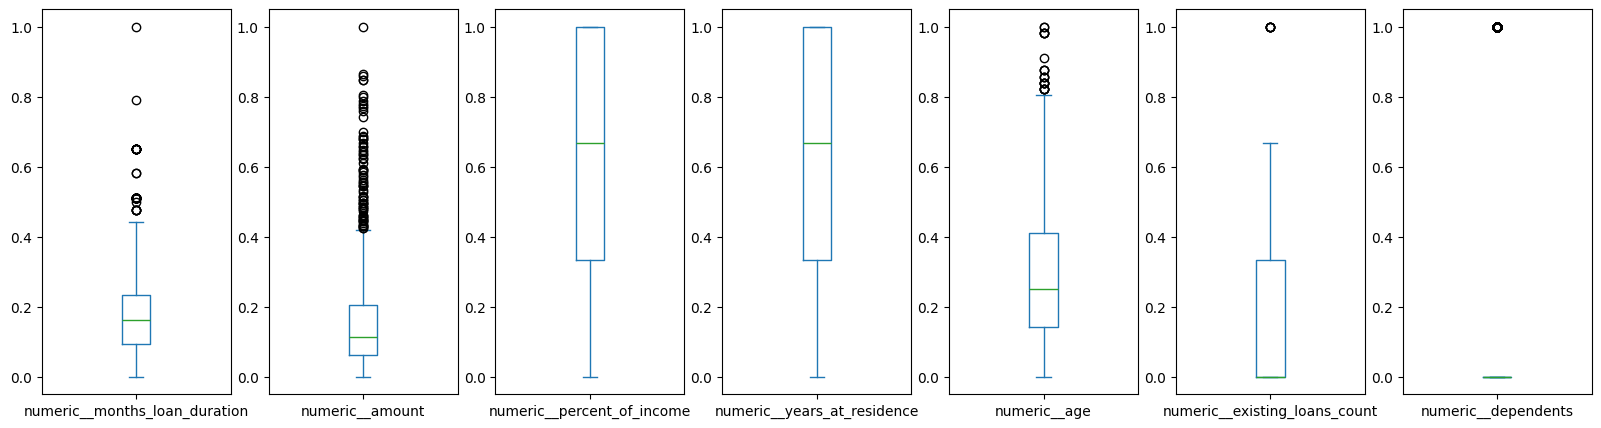

In [15]:
clean_data.iloc[:, 0:7].plot(kind = 'box', subplots = True, sharey = False, figsize = (20, 5))
plt.show() 


#### Outlier analysis: Columns 'months_loan_duration', 'amount', and 'age' are continuous, hence outliers are treated

In [16]:
winsor = Winsorizer(capping_method = 'iqr', # choose  IQR rule boundaries or gaussian for mean and std
                          tail = 'both', # cap left, right or both tails 
                          fold = 1.5,
                          variables = ['numeric__months_loan_duration',	'numeric__amount','numeric__age'])

In [17]:
outlier = winsor.fit(clean_data[['numeric__months_loan_duration', 'numeric__amount','numeric__age']])

In [18]:
clean_data[['numeric__months_loan_duration', 'numeric__amount','numeric__age']] = outlier.transform(clean_data[['numeric__months_loan_duration', 'numeric__amount','numeric__age']])

**Boxplot after cleaning**

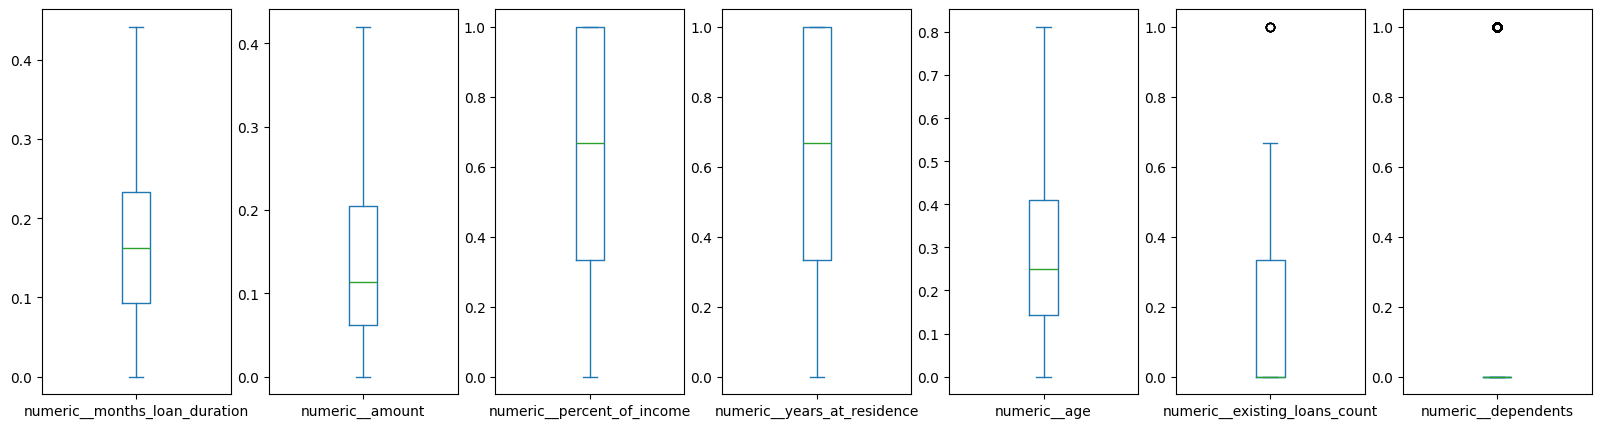

In [19]:
clean_data.iloc[:, 0:7].plot(kind = 'box', subplots = True, sharey = False, figsize = (20, 5))
plt.show() 

In [20]:
clean_data.head()

,numeric__months_loan_duration,numeric__amount,numeric__percent_of_income,numeric__years_at_residence,numeric__age,numeric__existing_loans_count,numeric__dependents,categorical__checking_balance_1 - 200 DM,categorical__checking_balance_< 0 DM,categorical__checking_balance_> 200 DM,...,categorical__housing_own,categorical__housing_rent,categorical__job_management,categorical__job_skilled,categorical__job_unemployed,categorical__job_unskilled,categorical__phone_no,categorical__phone_yes,categorical__default_no,categorical__default_yes
0,0.023256,0.050567,1.000000,1.000000,0.812500,0.333333,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.441860,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.093023,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.441860,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.232558,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
import pandas as pd

df = pd.read_csv('../artifacts/data_preprocessing/preprocessedDataset.csv')

In [10]:
df['categorical__default_yes'].value_counts()

categorical__default_yes
0.0    700
1.0    300
Name: count, dtype: int64